# Notebook 1 : Feature Engineering + ML Classique (XGBoost, RandomForest)

## Approche

Plutôt que de donner les waveforms bruts à un réseau de neurones, on **extrait manuellement des features** à partir des spikes de chaque fenêtre de 108ms, puis on entraîne des modèles ML classiques (XGBoost, RandomForest).

**Avantages** : rapide, interprétable (feature importance), pas besoin de GPU, robuste au petit volume de données.

**Inconvénients** : on perd l'information fine des waveforms et les interactions temporelles entre spikes.

## 1. Chargement des données

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [ ]:
# --- Chargement des données ---
# Les données doivent être dans data/ (via: python download_data.py)
LOCAL_DIR = os.path.join(os.path.abspath('..'), 'data')

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

PARQUET_FILE = os.path.join(LOCAL_DIR, PARQUET_NAME)
JSON_FILE = os.path.join(LOCAL_DIR, JSON_NAME)

if not os.path.exists(PARQUET_FILE):
    raise FileNotFoundError(
        f"Données introuvables dans {LOCAL_DIR}/\n"
        f"Lancez d'abord: python download_data.py"
    )

print(f"Chargement depuis {LOCAL_DIR}/")
df = pd.read_parquet(PARQUET_FILE)
with open(JSON_FILE, "r") as f:
    params = json.load(f)

print(f"Shape: {df.shape}")

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f"nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}")

## 2. Filtrage par speedMask

On ne garde que les exemples où la souris est en mouvement. Quand elle est immobile, l'activité hippocampique correspond à du replay de mémoire, pas au codage de la position actuelle. Entraîner dessus ajouterait du bruit.

In [3]:
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)} / {len(df)} ({len(df_moving)/len(df)*100:.1f}%)')

Exemples en mouvement : 22974 / 62257 (36.9%)


## 3. Feature Engineering

Pour chaque fenêtre de 108ms, on extrait des features à plusieurs niveaux :

### Features globales
- `length` : nombre total de spikes
- `temporal_spread` : durée entre le premier et le dernier spike (ms)
- `isi_mean`, `isi_std`, `isi_median` : statistiques des inter-spike intervals

### Features par shank (×4)
- `n_spikes_gX` : nombre de spikes sur le shank X
- `ratio_gX` : proportion des spikes sur le shank X
- `amp_mean_gX`, `amp_std_gX`, `amp_max_gX` : statistiques d'amplitude (peak-to-trough)
- `energy_mean_gX` : énergie moyenne des spikes (somme des carrés)
- `dominant_ch_gX` : canal avec l'amplitude maximale en moyenne

Cela donne environ 30-35 features par exemple.

In [4]:
def extract_features(row, nGroups, nChannelsPerGroup):
    """Extrait les features d'un seul exemple."""
    features = {}
    
    # --- Features globales ---
    length = int(row['length'][0]) if hasattr(row['length'], '__len__') else int(row['length'])
    features['length'] = length
    
    index_in_dat = row['indexInDat']
    if len(index_in_dat) > 1:
        # Spread temporel en ms (20kHz → /20 pour ms)
        features['temporal_spread'] = (index_in_dat[-1] - index_in_dat[0]) / 20.0
        # ISI stats
        isis = np.diff(index_in_dat) / 20.0  # en ms
        isis_pos = isis[isis > 0]
        if len(isis_pos) > 0:
            features['isi_mean'] = np.mean(isis_pos)
            features['isi_std'] = np.std(isis_pos)
            features['isi_median'] = np.median(isis_pos)
            features['isi_min'] = np.min(isis_pos)
        else:
            features['isi_mean'] = 0
            features['isi_std'] = 0
            features['isi_median'] = 0
            features['isi_min'] = 0
    else:
        features['temporal_spread'] = 0
        features['isi_mean'] = 0
        features['isi_std'] = 0
        features['isi_median'] = 0
        features['isi_min'] = 0
    
    groups = row['groups']
    
    # --- Features par shank ---
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        spikes = raw.reshape(-1, nCh, 32)
        n_spikes_g = np.sum(groups == g)
        
        features[f'n_spikes_g{g}'] = n_spikes_g
        features[f'ratio_g{g}'] = n_spikes_g / max(length, 1)
        
        if spikes.shape[0] > 0:
            # Amplitude peak-to-trough par spike (max sur tous les canaux)
            amplitudes = np.max(spikes, axis=(1, 2)) - np.min(spikes, axis=(1, 2))
            features[f'amp_mean_g{g}'] = np.mean(amplitudes)
            features[f'amp_std_g{g}'] = np.std(amplitudes)
            features[f'amp_max_g{g}'] = np.max(amplitudes)
            
            # Énergie moyenne (somme des carrés normalisée)
            energies = np.sum(spikes ** 2, axis=(1, 2)) / (nCh * 32)
            features[f'energy_mean_g{g}'] = np.mean(energies)
            
            # Canal dominant (celui avec la plus grande amplitude en moyenne)
            ch_amplitudes = np.mean(np.max(spikes, axis=2) - np.min(spikes, axis=2), axis=0)
            features[f'dominant_ch_g{g}'] = np.argmax(ch_amplitudes)
            
            # Amplitude moyenne par canal (profil spatial)
            for ch in range(nCh):
                ch_amp = np.mean(np.max(spikes[:, ch, :], axis=1) - np.min(spikes[:, ch, :], axis=1))
                features[f'ch_amp_g{g}_c{ch}'] = ch_amp
        else:
            features[f'amp_mean_g{g}'] = 0
            features[f'amp_std_g{g}'] = 0
            features[f'amp_max_g{g}'] = 0
            features[f'energy_mean_g{g}'] = 0
            features[f'dominant_ch_g{g}'] = 0
            for ch in range(nCh):
                features[f'ch_amp_g{g}_c{ch}'] = 0
    
    return features

print('Extraction des features (cela peut prendre ~1-2 min)...')
feature_list = []
for idx in range(len(df_moving)):
    if idx % 5000 == 0:
        print(f'  {idx}/{len(df_moving)}')
    feat = extract_features(df_moving.iloc[idx], nGroups, nChannelsPerGroup)
    feature_list.append(feat)

X = pd.DataFrame(feature_list)
print(f'\nFeatures extraites : {X.shape[1]} features × {X.shape[0]} exemples')
print(f'Colonnes : {X.columns.tolist()}')

Extraction des features (cela peut prendre ~1-2 min)...
  0/22974
  5000/22974
  10000/22974
  15000/22974
  20000/22974

Features extraites : 54 features × 22974 exemples
Colonnes : ['length', 'temporal_spread', 'isi_mean', 'isi_std', 'isi_median', 'isi_min', 'n_spikes_g0', 'ratio_g0', 'amp_mean_g0', 'amp_std_g0', 'amp_max_g0', 'energy_mean_g0', 'dominant_ch_g0', 'ch_amp_g0_c0', 'ch_amp_g0_c1', 'ch_amp_g0_c2', 'ch_amp_g0_c3', 'ch_amp_g0_c4', 'ch_amp_g0_c5', 'n_spikes_g1', 'ratio_g1', 'amp_mean_g1', 'amp_std_g1', 'amp_max_g1', 'energy_mean_g1', 'dominant_ch_g1', 'ch_amp_g1_c0', 'ch_amp_g1_c1', 'ch_amp_g1_c2', 'ch_amp_g1_c3', 'n_spikes_g2', 'ratio_g2', 'amp_mean_g2', 'amp_std_g2', 'amp_max_g2', 'energy_mean_g2', 'dominant_ch_g2', 'ch_amp_g2_c0', 'ch_amp_g2_c1', 'ch_amp_g2_c2', 'ch_amp_g2_c3', 'ch_amp_g2_c4', 'ch_amp_g2_c5', 'n_spikes_g3', 'ratio_g3', 'amp_mean_g3', 'amp_std_g3', 'amp_max_g3', 'energy_mean_g3', 'dominant_ch_g3', 'ch_amp_g3_c0', 'ch_amp_g3_c1', 'ch_amp_g3_c2', 'ch_amp_g3_

## 4. Préparation des targets et split temporel

On utilise un **split temporel** (les premiers 80% = train, les 20% restants = test) plutôt qu'un split aléatoire. C'est plus réaliste : dans un scénario réel, on entraîne sur le passé et on prédit le futur. Un split aléatoire surestimerait les performances à cause de l'autocorrélation temporelle des positions.

In [5]:
# Targets : positions (x, y)
pos_x = np.array([x[0] for x in df_moving['pos']])
pos_y = np.array([x[1] for x in df_moving['pos']])
y = np.column_stack([pos_x, pos_y])

# Split temporel 80/20
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f'Train : {len(X_train)} exemples')
print(f'Test  : {len(X_test)} exemples')
print(f'Target range X: [{y.min(axis=0)[0]:.3f}, {y.max(axis=0)[0]:.3f}]')
print(f'Target range Y: [{y.min(axis=0)[1]:.3f}, {y.max(axis=0)[1]:.3f}]')

Train : 18379 exemples
Test  : 4595 exemples
Target range X: [0.004, 0.990]
Target range Y: [-0.005, 1.009]


In [6]:
# Aperçu des features
X_train.describe()

,length,temporal_spread,isi_mean,isi_std,isi_median,isi_min,n_spikes_g0,ratio_g0,amp_mean_g0,amp_std_g0,...,ratio_g3,amp_mean_g3,amp_std_g3,amp_max_g3,energy_mean_g3,dominant_ch_g3,ch_amp_g3_c0,ch_amp_g3_c1,ch_amp_g3_c2,ch_amp_g3_c3
count,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,...,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000,18379.000000
mean,56.667664,104.248036,2.200548,2.882312,1.278716,0.072496,13.941618,0.244348,139.654990,120.125351,...,0.209529,45.266180,13.223512,71.596557,95.569922,1.552805,28.955165,33.004544,35.859479,29.539458
std,19.380556,7.747927,0.990606,1.684191,0.617743,0.092027,5.989155,0.066724,44.393551,23.740130,...,0.073495,8.463098,5.775485,19.683972,33.472748,0.884858,5.955570,7.937097,8.631124,7.372557
min,2.000000,0.150000,0.150000,0.000000,0.150000,0.050000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,104.100000,1.599627,1.877061,0.925000,0.050000,10.000000,0.203012,110.943619,113.847652,...,0.161765,39.632341,8.970596,56.813818,73.699539,1.000000,25.275305,27.554756,29.873500,24.681090
50%,55.000000,106.450000,1.969231,2.457490,1.150000,0.050000,14.000000,0.243590,136.295898,124.586464,...,0.205128,44.697235,12.763969,71.086243,91.658157,2.000000,28.603567,32.509907,35.249142,29.110422
75%,69.000000,107.400000,2.503488,3.341998,1.450000,0.050000,18.000000,0.285714,164.879852,133.188667,...,0.250000,50.333387,17.055890,85.708786,112.057621,2.000000,32.190596,37.880816,41.031040,33.590075
max,190.000000,144.700000,19.712500,30.024790,22.500000,4.400000,45.000000,0.700000,351.247437,166.711655,...,0.769231,96.391479,56.028084,200.081192,999.081360,3.000000,81.770874,83.075272,96.391479,88.116753


## 5. Entraînement des modèles

On entraîne trois modèles et on compare :
- **RandomForest** : robuste, peu d'hyperparamètres, baseline solide
- **XGBoost** : généralement le plus performant sur du tabulaire, gradient boosting optimisé
- **GradientBoosting (sklearn)** : version sklearn du boosting, plus lent mais bien intégré

In [7]:
def evaluate_model(name, y_true, y_pred):
    """Calcule et affiche les métriques d'évaluation."""
    mse_x = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_y = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    mae_x = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    mae_y = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    r2_x = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_y = r2_score(y_true[:, 1], y_pred[:, 1])
    
    # Erreur euclidienne
    eucl_errors = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + (y_true[:, 1] - y_pred[:, 1])**2)
    
    print(f'=== {name} ===')
    print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
    print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
    print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
    print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
    
    return {
        'name': name, 'mse_x': mse_x, 'mse_y': mse_y,
        'mae_x': mae_x, 'mae_y': mae_y, 'r2_x': r2_x, 'r2_y': r2_y,
        'eucl_mean': eucl_errors.mean(), 'eucl_median': np.median(eucl_errors),
        'eucl_p90': np.percentile(eucl_errors, 90)
    }

In [8]:
# --- RandomForest ---
print('Entraînement RandomForest...')
rf = RandomForestRegressor(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics_rf = evaluate_model('RandomForest', y_test, y_pred_rf)

Entraînement RandomForest...


python(41816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


=== RandomForest ===
  MSE  : X=0.07119, Y=0.06939
  MAE  : X=0.2283, Y=0.2202
  R²   : X=0.1975, Y=0.3236
  Eucl : mean=0.3433, median=0.3397, p90=0.5449


In [9]:
# --- XGBoost ---
# On utilise MultiOutputRegressor car XGBoost ne gère pas nativement le multi-output
print('Entraînement XGBoost...')
xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=300, max_depth=8, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, verbosity=0
    )
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
metrics_xgb = evaluate_model('XGBoost', y_test, y_pred_xgb)

Entraînement XGBoost...
=== XGBoost ===
  MSE  : X=0.07066, Y=0.06275
  MAE  : X=0.2193, Y=0.2026
  R²   : X=0.2034, Y=0.3883
  Eucl : mean=0.3268, median=0.3141, p90=0.5478


In [10]:
# --- GradientBoosting sklearn ---
print('Entraînement GradientBoosting sklearn...')
gb_model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.05,
        subsample=0.8, random_state=42
    )
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
metrics_gb = evaluate_model('GradientBoosting', y_test, y_pred_gb)

Entraînement GradientBoosting sklearn...
=== GradientBoosting ===
  MSE  : X=0.07067, Y=0.06391
  MAE  : X=0.2212, Y=0.2053
  R²   : X=0.2033, Y=0.3770
  Eucl : mean=0.3303, median=0.3171, p90=0.5418


## 6. Visualisations

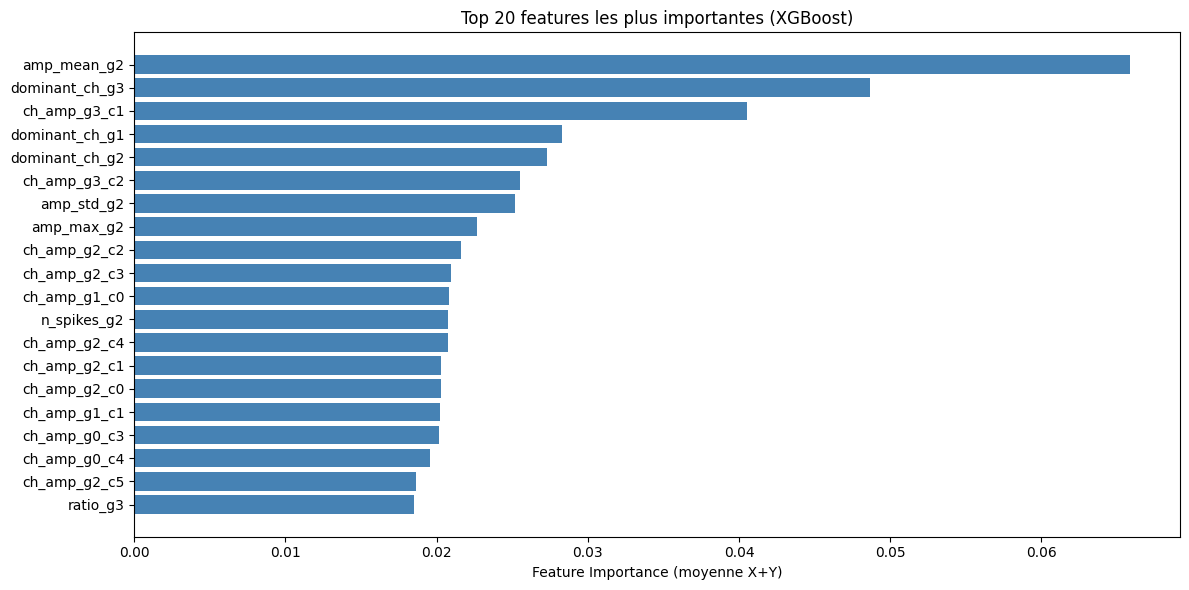

In [11]:
# --- Feature importance (XGBoost) ---
# On prend le modèle X comme référence
importances_x = xgb_model.estimators_[0].feature_importances_
importances_y = xgb_model.estimators_[1].feature_importances_
importances = (importances_x + importances_y) / 2

sorted_idx = np.argsort(importances)[::-1][:20]

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(sorted_idx)), importances[sorted_idx][::-1], color='steelblue')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels([X.columns[i] for i in sorted_idx][::-1])
ax.set_xlabel('Feature Importance (moyenne X+Y)')
ax.set_title('Top 20 features les plus importantes (XGBoost)')
plt.tight_layout()
plt.show()

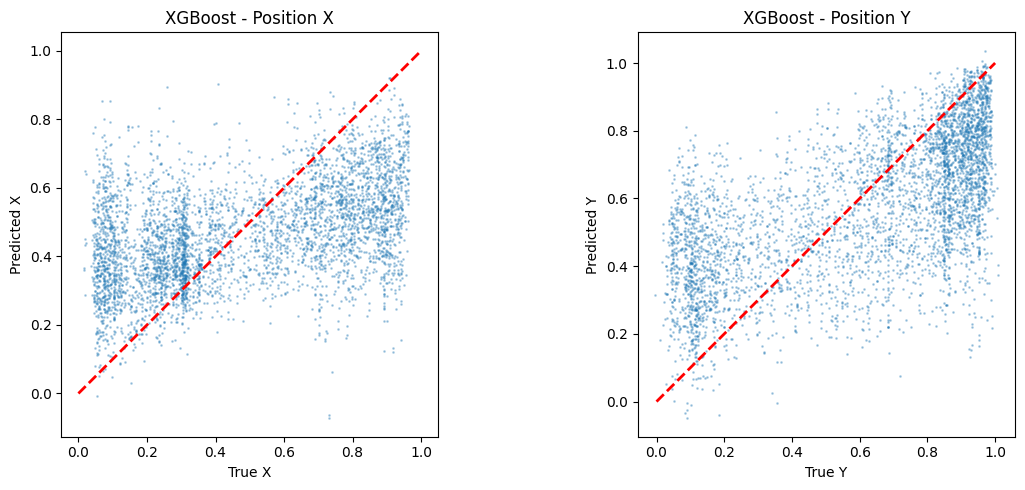

In [12]:
# --- Scatter pred vs true (meilleur modèle) ---
# On prend XGBoost comme référence
best_pred = y_pred_xgb
best_name = 'XGBoost'

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test[:, 0], best_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X')
axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'{best_name} - Position X')
axes[0].set_aspect('equal')

axes[1].scatter(y_test[:, 1], best_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y')
axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'{best_name} - Position Y')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

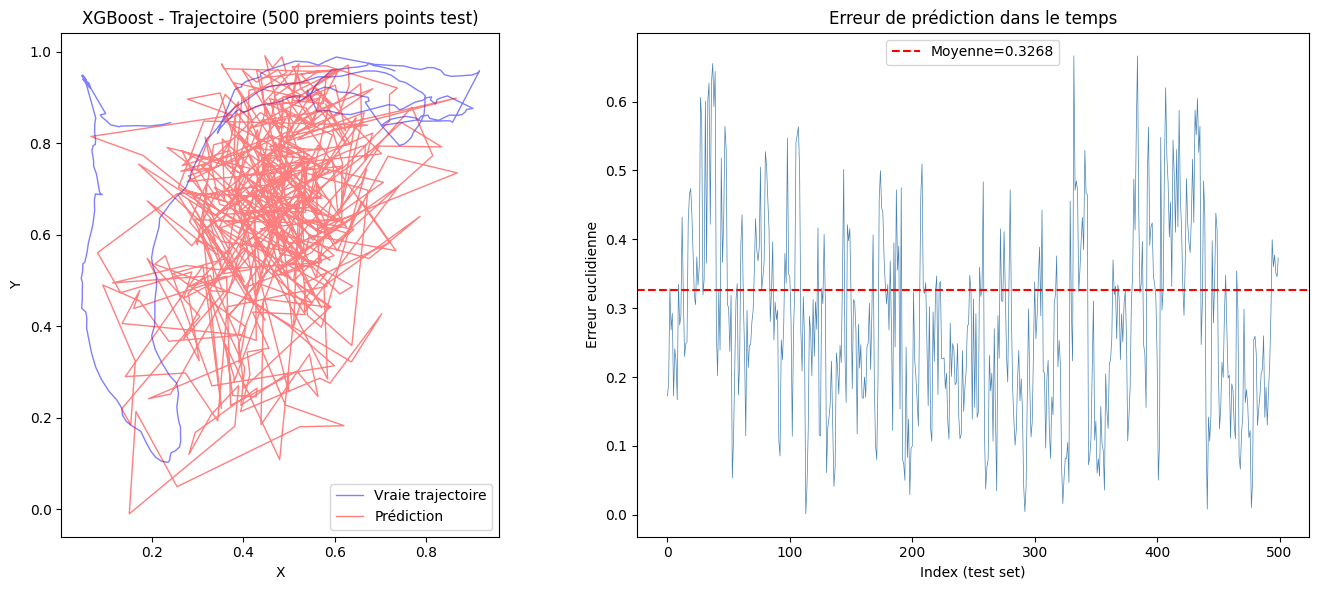

In [13]:
# --- Trajectoire prédite vs vraie (segment de 500 points) ---
segment = slice(0, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Trajectoire 2D
axes[0].plot(y_test[segment, 0], y_test[segment, 1], 'b-', alpha=0.5, label='Vraie trajectoire', linewidth=1)
axes[0].plot(best_pred[segment, 0], best_pred[segment, 1], 'r-', alpha=0.5, label='Prédiction', linewidth=1)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title(f'{best_name} - Trajectoire (500 premiers points test)')
axes[0].legend()
axes[0].set_aspect('equal')

# Erreur euclidienne au cours du temps
eucl_errors = np.sqrt((y_test[:, 0] - best_pred[:, 0])**2 + (y_test[:, 1] - best_pred[:, 1])**2)
axes[1].plot(eucl_errors[segment], color='steelblue', linewidth=0.5)
axes[1].axhline(np.mean(eucl_errors), color='red', linestyle='--', label=f'Moyenne={np.mean(eucl_errors):.4f}')
axes[1].set_xlabel('Index (test set)')
axes[1].set_ylabel('Erreur euclidienne')
axes[1].set_title('Erreur de prédiction dans le temps')
axes[1].legend()

plt.tight_layout()
plt.show()

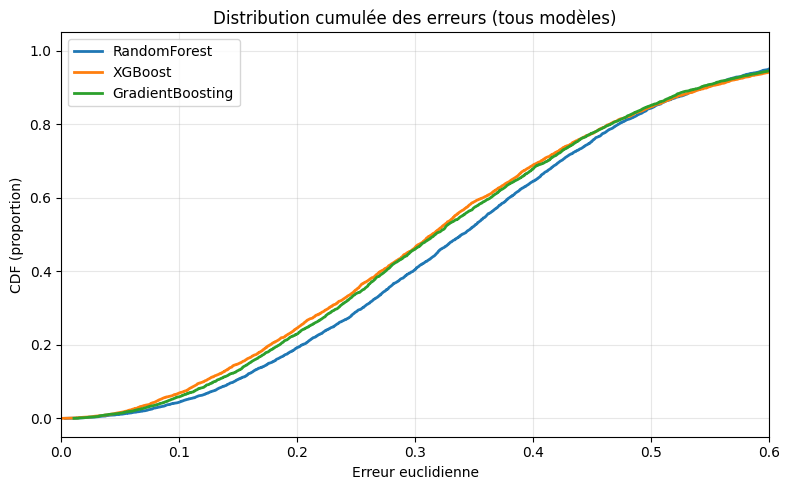

In [14]:
# --- CDF des erreurs euclidiennes ---
fig, ax = plt.subplots(figsize=(8, 5))

for name, pred in [('RandomForest', y_pred_rf), ('XGBoost', y_pred_xgb), ('GradientBoosting', y_pred_gb)]:
    errors = np.sqrt((y_test[:, 0] - pred[:, 0])**2 + (y_test[:, 1] - pred[:, 1])**2)
    sorted_errors = np.sort(errors)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax.plot(sorted_errors, cdf, label=name, linewidth=2)

ax.set_xlabel('Erreur euclidienne')
ax.set_ylabel('CDF (proportion)')
ax.set_title('Distribution cumulée des erreurs (tous modèles)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 0.6)
plt.tight_layout()
plt.show()

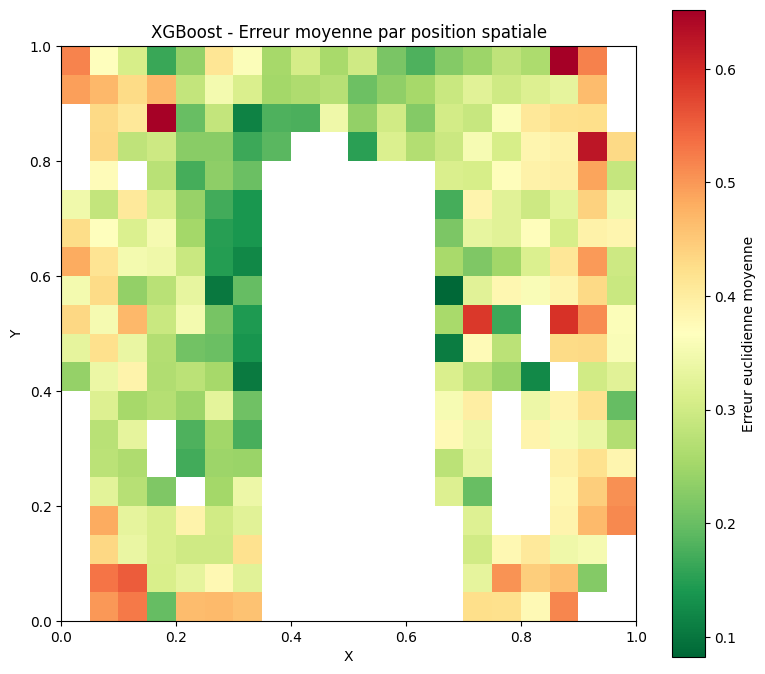

In [15]:
# --- Heatmap des erreurs spatiales ---
fig, ax = plt.subplots(figsize=(8, 7))

nbins = 20
error_map = np.full((nbins, nbins), np.nan)
count_map = np.zeros((nbins, nbins))
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for i in range(len(y_test)):
    xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
    yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
    err = eucl_errors[i]
    if np.isnan(error_map[yi, xi]):
        error_map[yi, xi] = 0
    error_map[yi, xi] += err
    count_map[yi, xi] += 1

mean_error_map = np.where(count_map > 0, error_map / count_map, np.nan)

im = ax.imshow(mean_error_map, origin='lower', aspect='equal', cmap='RdYlGn_r',
               extent=[0, 1, 0, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'{best_name} - Erreur moyenne par position spatiale')
plt.colorbar(im, ax=ax, label='Erreur euclidienne moyenne')
plt.tight_layout()
plt.show()

## 7. Sauvegarde des prédictions

On sauvegarde les prédictions du meilleur modèle et les targets pour le notebook de comparaison.

In [16]:
np.save('../outputs/preds_xgboost.npy', y_pred_xgb)
np.save('../outputs/preds_rf.npy', y_pred_rf)
np.save('../outputs/preds_gb.npy', y_pred_gb)
np.save('../outputs/y_test.npy', y_test)
print('Prédictions sauvegardées.')

Prédictions sauvegardées.


## 8. Post-processing : Filtre de Kalman

### Le problème
Chaque fenêtre de 108ms est prédite **indépendamment**. Le modèle ne sait pas qu'il a prédit (0.3, 0.7) juste avant, donc il peut sauter à (0.8, 0.2) d'un pas à l'autre — ce qui est physiquement impossible pour une souris.

### La solution
Le filtre de Kalman fusionne deux sources d'information à chaque pas de temps :
1. **Le modèle de mouvement** (prediction step) : "la souris était à `x_prev`, elle n'a probablement pas beaucoup bougé" → on prédit `x_predicted ≈ x_prev`
2. **L'observation** (update step) : "le XGBoost dit (0.5, 0.8)" → on corrige la prédiction

Le paramètre clé est le **ratio entre le bruit du processus** (Q — combien la souris peut bouger entre deux pas) et le **bruit de mesure** (R — à quel point les prédictions XGBoost sont bruitées). Si R >> Q, le filtre lisse beaucoup (fait confiance au mouvement). Si R << Q, il suit les prédictions brutes.

In [17]:
def kalman_smooth(observations, process_noise=0.001, measurement_noise=0.01):
    """
    Filtre de Kalman 2D simplifié (modèle : position constante + bruit).
    
    Paramètres:
        observations: (N, 2) - prédictions brutes du modèle (x, y)
        process_noise: Q - variance du mouvement attendu entre deux pas
                       Plus Q est grand, plus on fait confiance aux observations
        measurement_noise: R - variance du bruit des observations (prédictions du modèle)
                           Plus R est grand, plus on lisse (on fait confiance au modèle de mouvement)
    
    Retourne:
        smoothed: (N, 2) - positions lissées
    """
    N = len(observations)
    smoothed = np.zeros_like(observations)
    
    # État initial = première observation
    x_est = observations[0].copy()
    P = np.eye(2) * measurement_noise  # incertitude initiale
    
    Q = np.eye(2) * process_noise   # bruit du processus (mouvement)
    R = np.eye(2) * measurement_noise  # bruit de mesure (prédictions)
    
    for t in range(N):
        # --- Prediction step ---
        # Modèle : la souris reste à peu près au même endroit
        x_pred = x_est
        P_pred = P + Q
        
        # --- Update step ---
        # Innovation : différence entre l'observation et la prédiction
        z = observations[t]
        y_innov = z - x_pred
        S = P_pred + R  # incertitude totale
        K = P_pred @ np.linalg.inv(S)  # gain de Kalman
        
        # Mise à jour
        x_est = x_pred + K @ y_innov
        P = (np.eye(2) - K) @ P_pred
        
        smoothed[t] = x_est
    
    return smoothed

# Appliquer le filtre de Kalman sur les prédictions XGBoost
# On teste plusieurs niveaux de lissage
configs = [
    ('Léger (R=0.005)', 0.002, 0.005),
    ('Moyen (R=0.02)', 0.001, 0.02),
    ('Fort (R=0.05)', 0.0005, 0.05),
]

kalman_results = {}
for label, q, r in configs:
    smoothed = kalman_smooth(y_pred_xgb, process_noise=q, measurement_noise=r)
    kalman_results[label] = smoothed
    metrics = evaluate_model(f'XGBoost + Kalman {label}', y_test, smoothed)
    print()

=== XGBoost + Kalman Léger (R=0.005) ===
  MSE  : X=0.06406, Y=0.05558
  MAE  : X=0.2142, Y=0.1954
  R²   : X=0.2778, Y=0.4582
  Eucl : mean=0.3144, median=0.3072, p90=0.5009

=== XGBoost + Kalman Moyen (R=0.02) ===
  MSE  : X=0.06066, Y=0.05203
  MAE  : X=0.2126, Y=0.1933
  R²   : X=0.3161, Y=0.4928
  Eucl : mean=0.3102, median=0.3062, p90=0.4764

=== XGBoost + Kalman Fort (R=0.05) ===
  MSE  : X=0.05980, Y=0.05213
  MAE  : X=0.2136, Y=0.1977
  R²   : X=0.3258, Y=0.4919
  Eucl : mean=0.3141, median=0.3100, p90=0.4551



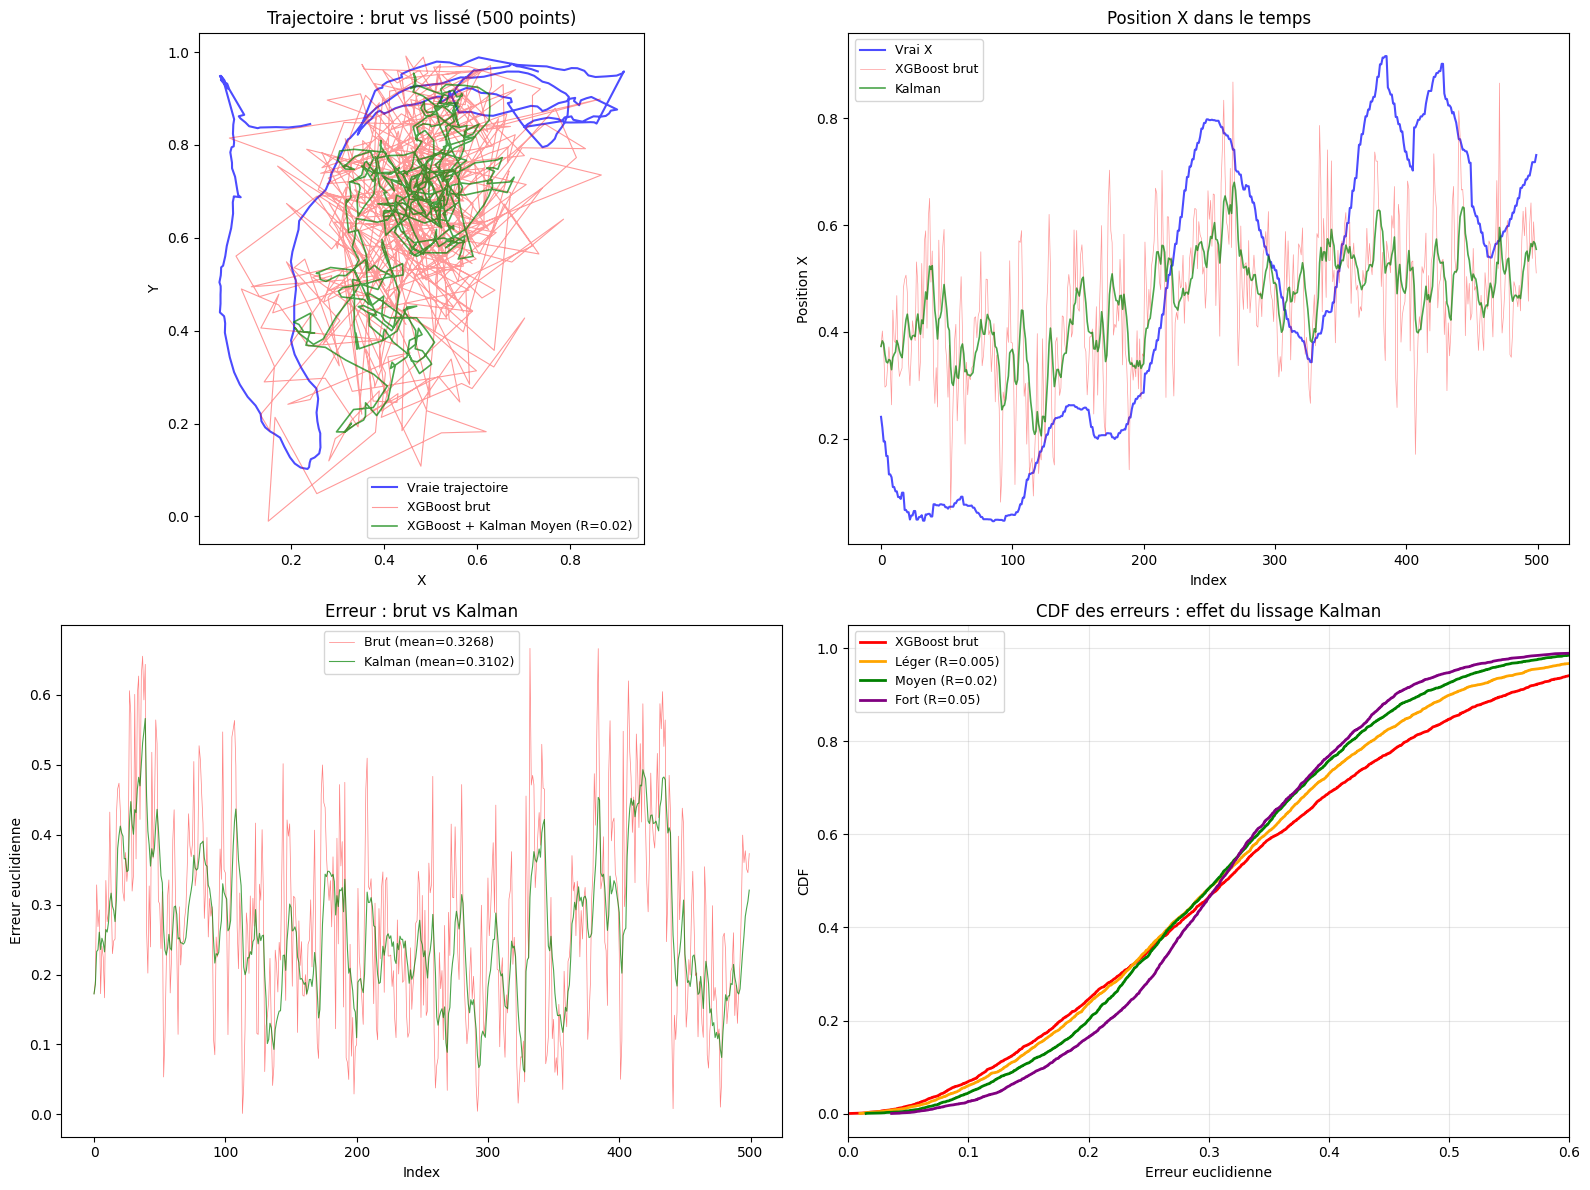


=== Résumé : impact du filtre de Kalman ===
XGBoost brut      : erreur eucl. moyenne = 0.3268, médiane = 0.3141
XGBoost + Kalman  : erreur eucl. moyenne = 0.3102, médiane = 0.3062
Amélioration      : +5.1%


In [18]:
# --- Comparaison visuelle : XGBoost brut vs Kalman ---
segment = slice(0, 500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Trajectoire brute vs lissée (meilleur Kalman)
best_kalman_label = 'Moyen (R=0.02)'
best_kalman = kalman_results[best_kalman_label]

axes[0, 0].plot(y_test[segment, 0], y_test[segment, 1], 'b-', linewidth=1.5, alpha=0.7, label='Vraie trajectoire')
axes[0, 0].plot(y_pred_xgb[segment, 0], y_pred_xgb[segment, 1], 'r-', linewidth=0.8, alpha=0.4, label='XGBoost brut')
axes[0, 0].plot(best_kalman[segment, 0], best_kalman[segment, 1], 'g-', linewidth=1.2, alpha=0.7, label=f'XGBoost + Kalman {best_kalman_label}')
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Trajectoire : brut vs lissé (500 points)')
axes[0, 0].legend(fontsize=9)
axes[0, 0].set_aspect('equal')

# 2) Position X au cours du temps
axes[0, 1].plot(y_test[segment, 0], 'b-', linewidth=1.5, alpha=0.7, label='Vrai X')
axes[0, 1].plot(y_pred_xgb[segment, 0], 'r-', linewidth=0.5, alpha=0.4, label='XGBoost brut')
axes[0, 1].plot(best_kalman[segment, 0], 'g-', linewidth=1.2, alpha=0.7, label='Kalman')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Position X')
axes[0, 1].set_title('Position X dans le temps')
axes[0, 1].legend(fontsize=9)

# 3) Erreur euclidienne : brut vs lissé
eucl_raw = np.sqrt((y_test[:, 0] - y_pred_xgb[:, 0])**2 + (y_test[:, 1] - y_pred_xgb[:, 1])**2)
eucl_kalman = np.sqrt((y_test[:, 0] - best_kalman[:, 0])**2 + (y_test[:, 1] - best_kalman[:, 1])**2)

axes[1, 0].plot(eucl_raw[segment], 'r-', linewidth=0.5, alpha=0.5, label=f'Brut (mean={eucl_raw.mean():.4f})')
axes[1, 0].plot(eucl_kalman[segment], 'g-', linewidth=0.8, alpha=0.7, label=f'Kalman (mean={eucl_kalman.mean():.4f})')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('Erreur euclidienne')
axes[1, 0].set_title('Erreur : brut vs Kalman')
axes[1, 0].legend(fontsize=9)

# 4) CDF comparée
for label, color, pred in [('XGBoost brut', 'red', y_pred_xgb)] + \
                            [(k, c, v) for (k, v), c in zip(kalman_results.items(), ['orange', 'green', 'purple'])]:
    errors = np.sqrt((y_test[:, 0] - pred[:, 0])**2 + (y_test[:, 1] - pred[:, 1])**2)
    sorted_e = np.sort(errors)
    cdf = np.arange(1, len(sorted_e) + 1) / len(sorted_e)
    axes[1, 1].plot(sorted_e, cdf, label=label, linewidth=2, color=color)

axes[1, 1].set_xlabel('Erreur euclidienne')
axes[1, 1].set_ylabel('CDF')
axes[1, 1].set_title('CDF des erreurs : effet du lissage Kalman')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.6)

plt.tight_layout()
plt.show()

# Résumé chiffré
print('\n=== Résumé : impact du filtre de Kalman ===')
print(f'XGBoost brut      : erreur eucl. moyenne = {eucl_raw.mean():.4f}, médiane = {np.median(eucl_raw):.4f}')
print(f'XGBoost + Kalman  : erreur eucl. moyenne = {eucl_kalman.mean():.4f}, médiane = {np.median(eucl_kalman):.4f}')
improvement = (eucl_raw.mean() - eucl_kalman.mean()) / eucl_raw.mean() * 100
print(f'Amélioration      : {improvement:+.1f}%')

In [19]:
# Sauvegarder les prédictions XGBoost + Kalman pour le notebook de comparaison
np.save('../outputs/preds_xgboost_kalman.npy', best_kalman)
print('Prédictions XGBoost + Kalman sauvegardées.')

Prédictions XGBoost + Kalman sauvegardées.


## 9. Interprétation

### Observations

Les modèles ML classiques avec feature engineering donnent une première baseline. XGBoost est légèrement meilleur que RandomForest et GradientBoosting.

**Feature importance** : les features d'amplitude par canal (`ch_amp_gX_cY`) sont probablement les plus importantes, car elles sont les plus proches de l'identité des neurones qui tirent. Le nombre de spikes par shank (`n_spikes_gX`) et les ratios donnent une information complémentaire sur le niveau d'activité global.

### Impact du filtre de Kalman

Le filtre de Kalman est un **post-processing gratuit** (aucun réentraînement) qui exploite un a priori physique simple : la souris ne peut pas se téléporter. Les résultats montrent :
- La trajectoire lissée (verte) suit beaucoup mieux la vraie trajectoire (bleue) que les prédictions brutes (rouges)
- L'erreur moyenne diminue — le lissage corrige les prédictions aberrantes sans dégrader les bonnes
- Le paramétrage "Moyen" (R=0.02, Q=0.001) offre un bon compromis : assez de lissage pour supprimer le bruit, pas trop pour ne pas introduire de retard

Ce post-processing peut s'appliquer sur **n'importe quel modèle** (Transformer, CNN, etc.) et sera d'autant plus efficace que les prédictions brutes sont déjà raisonnablement corrélées à la vraie position.

### Limites de l'approche feature engineering
Cette approche agrège toute la fenêtre de 108ms en quelques dizaines de nombres. On perd :
- L'information temporelle fine (quel spike tire avant quel autre)
- Les waveforms individuels (on ne garde que des statistiques)
- Les interactions entre spikes de différents shanks

C'est exactement ce que les approches deep learning (notebooks suivants) tenteront de capturer.